In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import scipy.io
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.utils.data
%matplotlib inline
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500"



/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dev/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:

df=pd.read_csv('/home/dev/Downloads/mpii_dataset.csv')



In [4]:
from sklearn.model_selection import train_test_split
df.drop(['Category','Activity'],1)
df = df.sample(n = len(df)).reset_index(drop=True)

/tmp/ipykernel_19542/934581437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Category','Activity'],1)


In [5]:
df.head()
from torch.utils.data import Dataset


In [6]:
transferdata_df = df.iloc[- 1400:, 0:]

test_df = pd.DataFrame()
test_df= test_df.append(transferdata_df)
train_df =df.drop(transferdata_df.index)
test_df = test_df.reset_index(drop=True)
test_df.head()

/tmp/ipykernel_19542/1936806666.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df= test_df.append(transferdata_df)


,Unnamed: 0,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,033826751.jpg,-1,-1,-1,-1,249,372,366,393,...,161,403,167,453,298,350,392,3.441386,"painting inside house,wallpapering, scraping p...",home repair
1,0,004001313.jpg,300,384,293,312,266,266,287,270,...,188,312,195,327,226,346,254,1.138420,walking the dog,walking
2,0,078491215.jpg,267,306,265,233,258,223,287,222,...,177,292,169,307,206,306,199,1.192295,reclining,inactivity quiet/light
3,0,049549132.jpg,886,653,966,531,886,468,783,479,...,292,794,290,720,336,745,458,2.959892,hacky sack,sports
4,0,087019669.jpg,374,263,364,276,385,182,447,177,...,186,448,134,493,119,446,184,2.895657,"laying tile or linoleum,repairing appliances",home repair


In [72]:
img_loc=("/home/dev/Downloads/Images/images/")
#imgArray = np.array([])
#files = glob.glob(img_loc+'*.jpg')
imgcomb=[]
from numpy import copy
from sklearn.decomposition import PCA
from PIL import Image
images=[]       
trainimglabels=train_df.loc[:,'r ankle_X':'Scale']
trainfilenames=train_df['NAME']

testimglabels=test_df.loc[:,'r ankle_X':'Scale']
testfilenames=test_df['NAME']

class Imagedataset(Dataset):
    def __init__(self,fnames,labels,transform=None):
        self.fnames=fnames
        self.labels=labels
        self.transform=transform
        self.CombArray=np.empty((0,16,2))
        self.BackupLabels=labels.copy()

    def __len__(self):
        return len(self.fnames)
    
    def NormaliseData(self,img,idx):
        #print(self.labels.head())
        height, width= img.shape
        #print(self.labels.head())
        Xcoord=[]
        Ycoord=[]
        x=0
       
        for i in range(0,31,2):
            self.labels.iloc[idx,i]=(self.labels.iloc[idx,i]*(256/width))
            Xcoord.append(self.labels.iloc[idx,i])
            self.labels.iloc[idx,i+1]=(self.labels.iloc[idx,i+1]*(256/height))
            Ycoord.append(self.labels.iloc[idx,i+1])
            x=x+1
        
        X_min=np.min(Xcoord)
        Y_min=np.min(Ycoord)
        X_max=np.max(Xcoord)
        Y_max=np.max(Ycoord)

        
    
        self.CombArray = np.concatenate((self.CombArray, np.stack((Xcoord, Ycoord), axis=1)[np.newaxis, :, :]), axis=0)
        """
        x=0
        for i in range(0,31,2):
            self.labels.iloc[idx, i] = (self.labels.iloc[idx, i] - X_min) / (X_max - X_min)
            self.labels.iloc[idx, i+1] = (self.labels.iloc[idx, i+1] - Y_min) / (Y_max - Y_min)
            x=x+1
        #print(self.labels.head())"""
        normImg=cv2.resize(img,(256,256))
        self.labels.astype(np.float32)
        return normImg
            
    def __getitem__ (self, idx):
        Rimg=cv2.imread(img_loc+self.fnames[idx])
        Gimg=cv2.cvtColor(Rimg,cv2.COLOR_BGR2GRAY)
        Gimg=self.NormaliseData(Gimg,idx)
        
        
        
        """
        PCA whitening, edge detection etc, nothing worked in helping the model learn.
        for i in range(0,31,2):
            y=self.labels.iloc[idx,i+1]
            x=self.labels.iloc[idx,i]
            cv2.circle(Gimg,(int(x),int(y)),5,(0,255,0),-1)
        cv2.imshow("gay", Gimg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        
        Gimg=Gimg.reshape(-1,Gimg.shape[-1])

        pca=PCA(n_components=None, whiten=True)
        pca.fit(Gimg)
        Timg=pca.transform(Gimg)
        Timg=Timg.reshape(-1,Gimg.shape[-1])
        img_shape=(256,256)
       
        Gimg = Gimg.reshape(img_shape[0], img_shape[1])
        Timg = Timg.reshape(img_shape[0], img_shape[1])
        Gimg = cv2.convertScaleAbs(Gimg)
        
       # img_merged = cv2.merge([Timg[:, :, 0], Timg[:, :, 0], Timg[:, :, 2]])
       
        
        #img_merged=cv2.cvtColor(img_merged,cv2.COLOR_BGR2GRAY)
       

        #print(Timg.shape)
        
        cv2.imshow("Original Image", edges)
       # cv2.imshow("Whitened Image", Timg)
        #cv2.imshow("Edge", Timg)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        """
        Gimg = Gimg.astype(np.float32) / 255.
        if self.transform:
            Gimg = self.transform(Gimg)
       
        helper=self.labels.iloc[idx, :-1]
       
        target=helper.values
        #target=target.reshape(-1,2)
        target.astype(np.float32)
      
        return (Gimg,target)

    def GetOgLabel(self):
        return (self.CombArray)
        
    def cleanup(self):
        del(self.CombArray)
        del(self.labels)
        #print(self.labels.shape)
        #self.labels=np.empty((15972, 33))
        self.labels=self.BackupLabels.copy()
        self.CombArray=np.empty((0,16,2))
    
train_dataset= Imagedataset(trainfilenames,trainimglabels)
test_dataset= Imagedataset(testfilenames,testimglabels)

train_loader=DataLoader(train_dataset,batch_size=5, shuffle=True, num_workers=12)
test_loader=DataLoader(test_dataset,batch_size=5, shuffle=True)




In [65]:
data, target= train_dataset.__getitem__(0)
#asdf=pd.DataFrame(data)
#a=train_dataset.GetOgLabel()


In [9]:

train_dataset.cleanup()

In [10]:

#print(a[0,:,0],'\t' ,a.shape)

In [11]:
#train_dataset.fnames.iloc[4]
import itertools

In [73]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5,stride=1,padding=1)
        self.conv7 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=5,stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=5,stride=1,padding=1)
       
   
        self.fc1 = nn.Linear(512*2*2,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,32)
        
        

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        X = self.conv3(X)
        X = self.conv4(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        X = self.conv4(X)
        X = self.conv5(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        X = self.conv6(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        X = self.conv7(X)
        X = self.conv8(X)
        X = self.conv8(X)
        X = F.max_pool2d(X,kernel_size=3,stride=2)
        
       
    
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X = F.leaky_relu(X)
        X = self.fc2(X)
        X=F.leaky_relu(X)
        X = self.fc3(X)
        
        
        

        X=X.view(-1,32,1)
        output =X
        return output
    
torch.manual_seed(101)
model = ConvolutionalNetwork().to(dev)
print(dev)

cuda:0


In [13]:
"""
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
        
    def forward(self, y_pred, y_true):
        error = y_pred - y_true
        abs_error = torch.abs(error)
        quadratic = torch.min(abs_error, torch.tensor(self.delta))
        linear = (abs_error - quadratic)
        loss = 0.5 * quadratic ** 2 + self.delta * linear
        return torch.mean(loss)
        """

'\nclass HuberLoss(nn.Module):\n    def __init__(self, delta=1.0):\n        super(HuberLoss, self).__init__()\n        self.delta = delta\n        \n    def forward(self, y_pred, y_true):\n        error = y_pred - y_true\n        abs_error = torch.abs(error)\n        quadratic = torch.min(abs_error, torch.tensor(self.delta))\n        linear = (abs_error - quadratic)\n        loss = 0.5 * quadratic ** 2 + self.delta * linear\n        return torch.mean(loss)\n        '

In [74]:

criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [75]:
def train(model, dev, train_loader, optimizer):
  
  model.train()
  EPOCHS = 50
  batch_size = 15
  id=0
  #for batch_idx in range(0,len(train_loader),batch_size):
  for epoch in range(EPOCHS):
    id=0
    print("Performing Cleanup")
    print("Loading Epoch...")
    train_dataset.cleanup()  
    for data, target in train_loader:
        
      data=data.unsqueeze(1)
      target=target.unsqueeze(2)
      #print("dik")
      #start_idx = batch_idx
      #end_idx = min(len(train_loader), batch_idx + 20)
    # batch=list(itertools.islice(train_loader,batch_size))
      ###for data, target in batch:
        #print("coc")
      #print(target[1,1])
      data, target = data.to(dev), target.to(dev)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output.float(), target.float())
      loss.backward()
      optimizer.step()
      
      
     # if(id%15==0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
        epoch, id * len(data), len(train_loader.dataset),
        100. * id / len(train_loader), loss.item()))
      if(id*len(data)==3000):
        break   
      id=id+1
    
        

In [16]:

#train_dataset.__getitem__(0)
#test_dataset.__getitem__(2)


In [62]:
torch.cuda.empty_cache()

In [78]:

 train(model, dev, train_loader, optimizer)

Performing Cleanup
Loading Epoch...
Train Epoch: 0 [0/15972 (0%)]	Loss: 24.325
Train Epoch: 0 [5/15972 (0%)]	Loss: 37.412
Train Epoch: 0 [10/15972 (0%)]	Loss: 37.161
Train Epoch: 0 [15/15972 (0%)]	Loss: 39.510
Train Epoch: 0 [20/15972 (0%)]	Loss: 62.750
Train Epoch: 0 [25/15972 (0%)]	Loss: 38.222
Train Epoch: 0 [30/15972 (0%)]	Loss: 37.264
Train Epoch: 0 [35/15972 (0%)]	Loss: 32.549
Train Epoch: 0 [40/15972 (0%)]	Loss: 40.431
Train Epoch: 0 [45/15972 (0%)]	Loss: 40.256
Train Epoch: 0 [50/15972 (0%)]	Loss: 44.436
Train Epoch: 0 [55/15972 (0%)]	Loss: 26.593
Train Epoch: 0 [60/15972 (0%)]	Loss: 32.645
Train Epoch: 0 [65/15972 (0%)]	Loss: 45.510
Train Epoch: 0 [70/15972 (0%)]	Loss: 45.821
Train Epoch: 0 [75/15972 (0%)]	Loss: 42.008
Train Epoch: 0 [80/15972 (1%)]	Loss: 40.222
Train Epoch: 0 [85/15972 (1%)]	Loss: 36.397
Train Epoch: 0 [90/15972 (1%)]	Loss: 47.478
Train Epoch: 0 [95/15972 (1%)]	Loss: 53.156
Train Epoch: 0 [100/15972 (1%)]	Loss: 54.440
Train Epoch: 0 [105/15972 (1%)]	Loss: 37.

KeyboardInterrupt: 

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    device = next(model.parameters()).device
    
    mpjpe = 0.0
    num_samples = 0
    mse = 0.0
    rmse = 0.0
    ssr = 0.0
    sst = 0.0
    with torch.no_grad():
        train_dataset.cleanup()
        test_dataset.cleanup()
        for data, target in data_loader:
            #print("wtf")
            target=target.unsqueeze(2)
            data=data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
        #MPJPE
            batch_mpjpe = torch.sqrt(torch.sum((output - target)**2, dim=-1)).mean()
            mpjpe += batch_mpjpe.item() * data.size(0)
            num_samples += data.size(0)
        #MSE
       
            batch_mse = loss.item() * data.size(0)
            mse += batch_mse
        
        #RMSE 
            batch_rmse = torch.sqrt(loss).item() * data.size(0)
            rmse += batch_rmse
        
        #SSR and SST 
            batch_ssr = torch.sum((output - target)**2).item()
            batch_sst = torch.sum((target - torch.mean(target))**2).item()
            ssr += batch_ssr
            sst += batch_sst
        
            num_samples += data.size(0)
    
    num_samples_total = num_samples * data_loader.batch_size   
    r2 = 1.0 - (ssr / sst)
    
    mse /= num_samples
    rmse /= num_samples
 
    avg_mpjpe = mpjpe / num_samples_total

    
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 score: {r2:.4f}, MPJPE: {mpjpe:.4f}')
            
   


In [ ]:
 evaluate(model, test_loader)


MSE: 8612.4913, RMSE: 65.5617, R2 score: -4.1709, MPJPE: 164826.1478


In [24]:
def predict_image(model, test_loader, device):
   
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        predictions_denorm=[]
        train_dataset.cleanup()
        test_dataset.cleanup()
        for i, (data, target) in enumerate(test_loader):
            if i== 1:
                break
            data=data.unsqueeze(1)
            target=target.unsqueeze(2)
            data=data.to(dev)
            predictions = model(data)

            predictions = predictions.cpu().numpy()
            #print(predictions.shape)
            target = target.cpu().numpy()
            
            """ 
            ogX=[]
            ogY=[]
            OgValues=test_dataset.GetOgLabel()
            for i in range(predictions.shape[0]):
                for k in range(0,OgValues.shape[1],2):
                    ogX.append(OgValues[i,k])
                    ogY.append(OgValues[i,k+1])
                X_min=np.min(ogX)
                Y_min=np.min(ogY)
                X_max=np.max(ogX)
                Y_max=np.max(ogY)
                for j in range(0,predictions.shape[1],2):
                    
                    predictions[i,j] = predictions[i, j] * (X_max-X_min)+X_min 
                    predictions[i,j+1] = predictions[i, j+1] * (Y_max-Y_min)+Y_min  
                    print(predictions[i,j])
                    print(predictions[i,j+1])
            """
            test_dataset.cleanup()
            
            #print("wft")
            # Plot the images with predicted keypoints
            for i in range(0,len(data)):
                

                img_data = np.transpose(data[i].cpu().numpy(), (1, 2, 0))
                plt.imshow(img_data)
                plt.scatter(predictions[i][::2], predictions[i][1::2] , s=50)
                print(predictions[i][::2],"\t\t", predictions[i][1::2])
                plt.show()


[[ 92.142105]
 [103.489944]
 [116.9681  ]
 [131.93013 ]
 [119.82137 ]
 [ 85.08715 ]
 [122.62945 ]
 [121.57584 ]
 [125.12222 ]
 [129.01372 ]
 [117.56662 ]
 [110.70487 ]
 [114.90594 ]
 [134.80652 ]
 [143.94759 ]
 [142.10313 ]] 		 [[153.89706 ]
 [143.38603 ]
 [131.94662 ]
 [142.36392 ]
 [152.62321 ]
 [144.26744 ]
 [140.33223 ]
 [106.499146]
 [ 96.45039 ]
 [ 49.431427]
 [120.917854]
 [122.94048 ]
 [ 96.62533 ]
 [111.68077 ]
 [114.015884]
 [124.69953 ]]


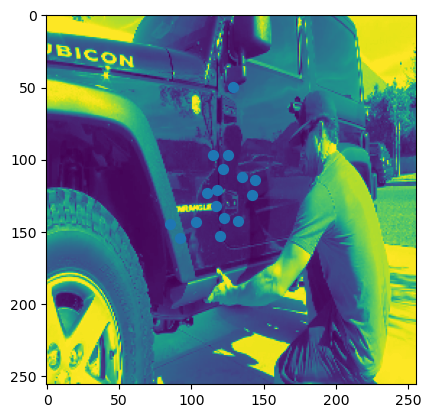

[[ 91.96022 ]
 [103.28575 ]
 [116.73472 ]
 [131.65659 ]
 [119.57448 ]
 [ 84.92363 ]
 [122.388504]
 [121.34524 ]
 [124.87348 ]
 [128.76433 ]
 [117.344055]
 [110.48209 ]
 [114.689064]
 [134.54163 ]
 [143.66759 ]
 [141.83234 ]] 		 [[153.59613 ]
 [143.10997 ]
 [131.68701 ]
 [142.085   ]
 [152.33527 ]
 [143.97981 ]
 [140.05215 ]
 [106.29397 ]
 [ 96.2542  ]
 [ 49.337017]
 [120.67881 ]
 [122.70965 ]
 [ 96.42678 ]
 [111.47453 ]
 [113.79107 ]
 [124.449875]]


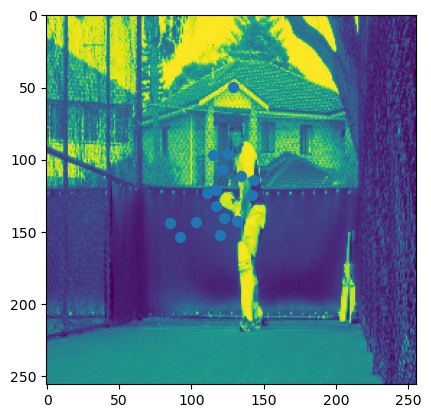

[[ 92.07284 ]
 [103.41229 ]
 [116.879585]
 [131.82735 ]
 [119.7286  ]
 [ 85.024376]
 [122.53779 ]
 [121.487015]
 [125.027565]
 [128.9181  ]
 [117.48074 ]
 [110.6204  ]
 [114.822395]
 [134.70541 ]
 [143.84048 ]
 [141.99905 ]] 		 [[153.78215]
 [143.28   ]
 [131.8476 ]
 [142.2575 ]
 [152.5121 ]
 [144.15823]
 [140.226  ]
 [106.4204 ]
 [ 96.37608]
 [ 49.39523]
 [120.8268 ]
 [122.85113]
 [ 96.55064]
 [111.60062]
 [113.93011]
 [124.60491]]


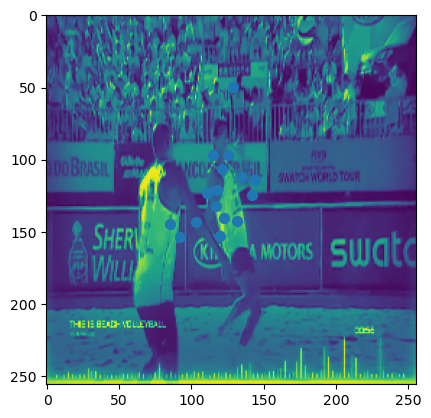

[[ 92.00793 ]
 [103.33944 ]
 [116.79605 ]
 [131.7282  ]
 [119.63924 ]
 [ 84.966675]
 [122.45173 ]
 [121.40593 ]
 [124.93874 ]
 [128.82964 ]
 [117.40241 ]
 [110.54037 ]
 [114.746216]
 [134.61125 ]
 [143.74112 ]
 [141.90346 ]] 		 [[153.67525 ]
 [143.18257 ]
 [131.75526 ]
 [142.15807 ]
 [152.41083 ]
 [144.05528 ]
 [140.12596 ]
 [106.34774 ]
 [ 96.305214]
 [ 49.361988]
 [120.74166 ]
 [122.76997 ]
 [ 96.478836]
 [111.52854 ]
 [113.85038 ]
 [124.515335]]


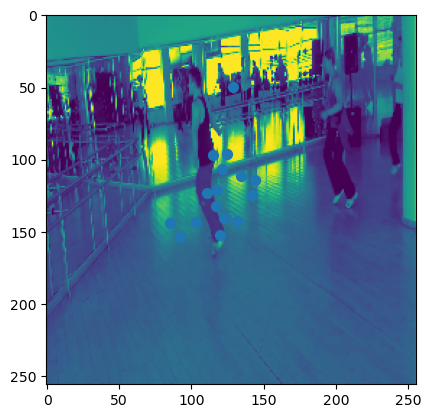

[[ 91.94378 ]
 [103.267426]
 [116.712715]
 [131.62695 ]
 [119.54835 ]
 [ 84.91042 ]
 [122.36678 ]
 [121.327515]
 [124.85022 ]
 [128.74297 ]
 [117.326614]
 [110.46012 ]
 [114.67245 ]
 [134.51787 ]
 [143.64322 ]
 [141.81056 ]] 		 [[153.56935 ]
 [143.08748 ]
 [131.66365 ]
 [142.05986 ]
 [152.31319 ]
 [143.9524  ]
 [140.02576 ]
 [106.27668 ]
 [ 96.23387 ]
 [ 49.329556]
 [120.6571  ]
 [122.69207 ]
 [ 96.405754]
 [111.46003 ]
 [113.77113 ]
 [124.42571 ]]


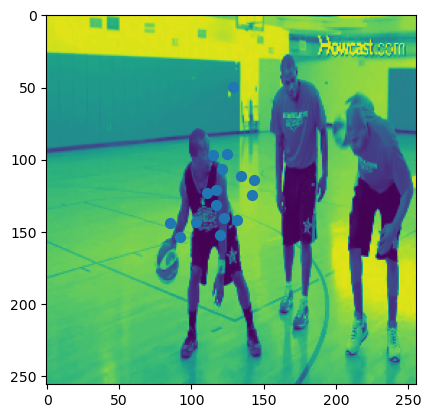

In [77]:
predict_image(model, test_loader, dev)